 Thanks to previous Notebooks  
 https://www.kaggle.com/cdeotte/part-2-rapids-tfidfvectorizer-cv-0-700  
 https://www.kaggle.com/muhammad4hmed/b3-tfidf-knn-boom-p  
 https://www.kaggle.com/parthdhameliya77/pytorch-eca-nfnet-l0-image-tfidf-inference
 

<center><h1>Introduction 📝</h1></center>

> 🎯Goal: To build a model that predicts which items are the same products
> 
> As a shopaholic🛍️ , I admit getting the best deals for products is a very rewarding experience. Scanning through multiple shopping websites to get the perfect deal and keeping an eye on upcoming sales is one manual way to go about.
> 
> We often find retail companies offering recommendations in which they promote their products in such a way that customers tend to get swayed and pick a similar product that is priced lower. Product matching 📋📋 is one of these strategies wherein a company to offers products at rates that are competitive to the same product sold by another retailer. 
> 
> These matches can be performed automatically with the help of machine learning and that is the goal of this competition. We have been provided with data of **Shopee**, which is the leading e-commerce platform in Southeast Asia and Taiwan. 

<center><h1>Diving into the Data 🤿 </h1></center>

> **train/test.csv** - Each row contains the data for a single posting. 
> 
> ℹ️Multiple postings might have the exact same image ID, but with different titles or vice versa.
> 
> - posting_id : the ID code for the posting
> - image : the image id/md5sum
> - image_phash : a perceptual hash of the image
> - title : the product description for the posting
> - label_group : ID code for all postings that map to the same product. Not provided for the test set
> - matches - **Space delimited** list of all posting IDs that match a particular posting. 
> 
> 📌Posts always self-match. 
> 
> 📌**Group sizes were capped at 50**, so we need not predict more than 50 matches for a posting.

<h1><center>Evaluation metric: <b>F1-score 🧪</b> </center></h1>

> The evaluation metric for this competition is F1-Score or F-Score.
> 
> <center><img src="https://www.gstatic.com/education/formulas2/355397047/en/f1_score.svg"></center>
> 
>  It finds the balance between precision and recall.
>  <center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d37e557b5bfc8de22afa8aad1c187a357ac81bdb"></center>
>  <center><img src="https://miro.medium.com/max/560/1*AEV3TE67ahMn3NVpU0ov4g.png" height=10></center>
>  
>  where-
>  - TP = True Positive
>  - FP = False Positive
>  - TN = True Negative
>  - FN = False Negative

In [1]:
import plotly.express as px
import numpy as np
import pandas as pd

import os
# import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from wordcloud import WordCloud, STOPWORDS

#Text Color
from termcolor import colored

#Data Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

#NLP
from sklearn.feature_extraction.text import CountVectorizer

#WordCloud
from wordcloud import WordCloud, STOPWORDS

#Text Processing
import re
import nltk
#Sentiment
from textblob import TextBlob

#ner
import spacy

#Vectorizer
from sklearn import feature_extraction, manifold

#Word Embedding
import gensim.downloader as gensim_api

#Topic Modeling
import gensim

from glob import glob

from bq_helper import BigQueryHelper
from dask import bag, diagnostics 
from urllib import request
import random
import missingno as msno
from PIL import Image

In [2]:
train = pd.read_csv('../input/shopee-product-matching/train.csv')
test = pd.read_csv('../input/shopee-product-matching/test.csv')
sample = pd.read_csv('../input/shopee-product-matching/sample_submission.csv')

In [3]:
train.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

In [4]:
def plot(num):
    IMG_PATHS = "../input/shopee-product-matching/train_images/"
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num), "Number of Images must be a perfect Square!"

    sq_num = int(sq_num)
    image_ids = os.listdir(IMG_PATHS)
    random.shuffle(image_ids)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(10, 10))

    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            img = cv2.imread(IMG_PATHS + '/' + image_ids[idx])
            img = img[:, :, ::-1]
            ax[i, j].imshow(img); ax[i, j].set_title(f'{image_ids[idx]}', fontsize=6.5)

    plt.show()
    
    
def plot_from_label(group):
    IMG_PATHS = "../input/shopee-product-matching/train_images/"
    image_list = train[train['label_group'] == group]
    image_list = image_list['image'].tolist()
    num = len(image_list)
    
    sq_num = np.sqrt(num)

    sq_num = int(sq_num)
    image_ids = os.listdir(IMG_PATHS)
    random.shuffle(image_ids)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(10, 10))
    
    path = [os.path.join(IMG_PATHS, x) for x in image_list]
    
    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            img = cv2.imread(path[idx])
            img = img[:, :, ::-1]
            ax[i, j].imshow(img)

    plt.show()

def plot_from_title(title):
    IMG_PATHS = "../input/shopee-product-matching/train_images/"
    image_list = train[train['title'] == title]
    image_list = image_list['image'].tolist()
    num = len(image_list)
    
    sq_num = np.sqrt(num)
    sq_num = int(sq_num)
    
    image_ids = os.listdir(IMG_PATHS)
    random.shuffle(image_ids)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(10, 10))
    fig.suptitle(f"Product Name: {title}")
    path = [os.path.join(IMG_PATHS, x) for x in image_list]
    
    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            img = cv2.imread(path[idx])
            img = img[:, :, ::-1]
            ax[i, j].imshow(img)
            
    plt.show()
    


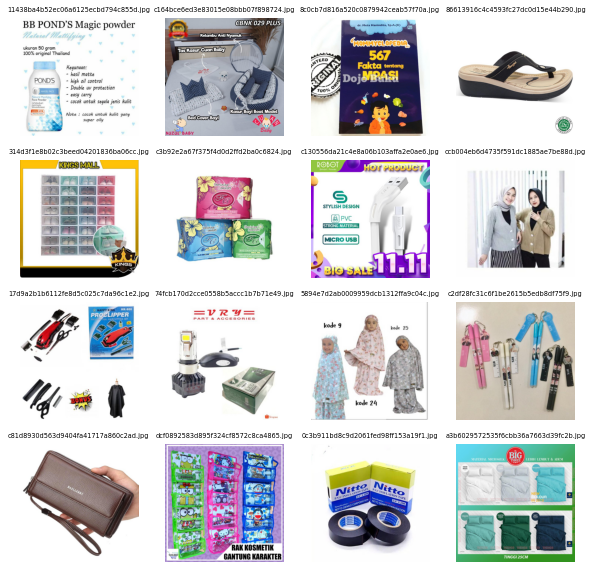

In [5]:
# Plot 16 random images
plot(16)

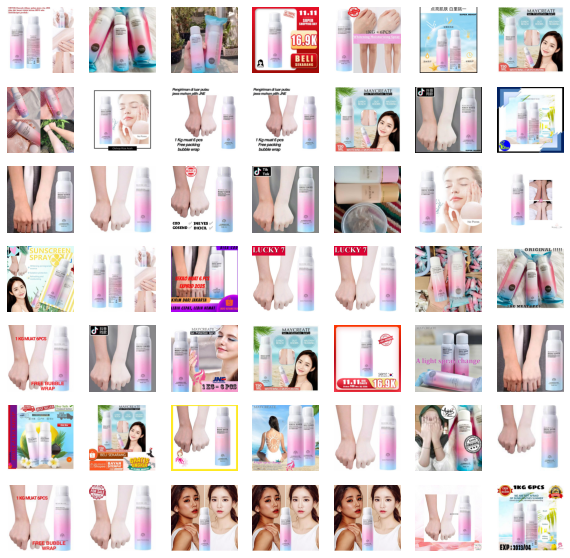

In [6]:
plot_from_label(1141798720)

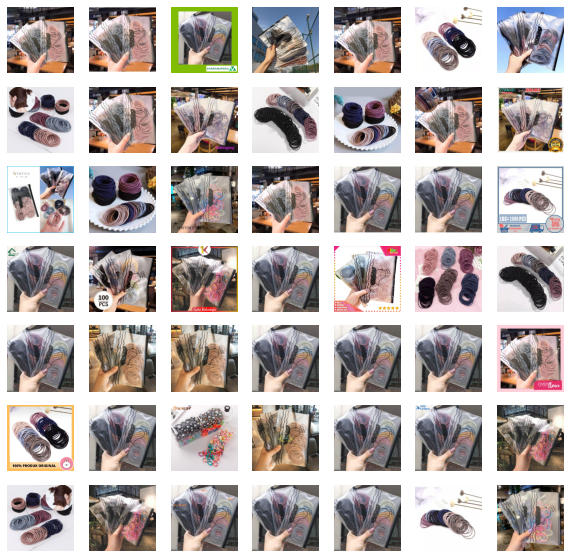

In [7]:
plot_from_label(994676122)

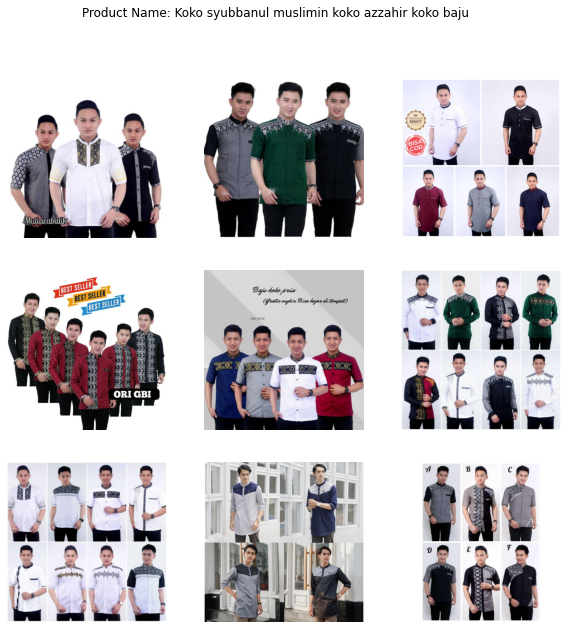

In [8]:
plot_from_title("Koko syubbanul muslimin koko azzahir koko baju")

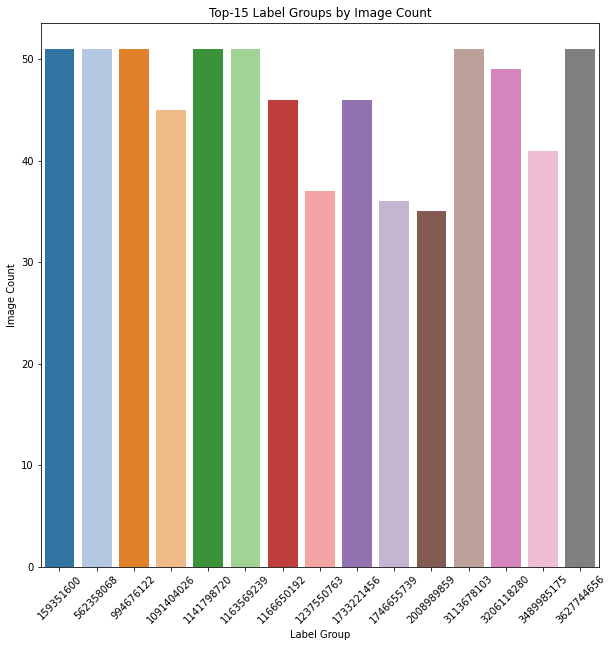

In [9]:
sns.set_palette("tab20")
top10_names = train['label_group'].value_counts().index.tolist()[:15]
top10_values = train['label_group'].value_counts().tolist()[:15]

plt.figure(figsize=(10, 10))
sns.barplot(x=top10_names, y=top10_values)
plt.xticks(rotation=45)
plt.xlabel("Label Group")
plt.ylabel("Image Count")
plt.title("Top-15 Label Groups by Image Count")
plt.show()

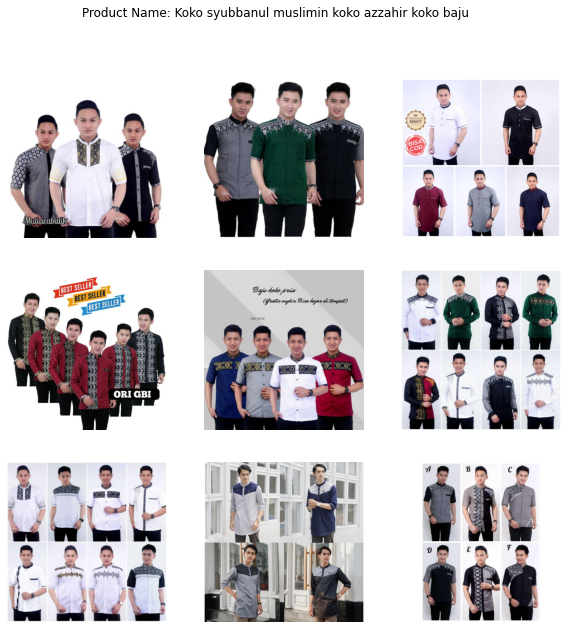

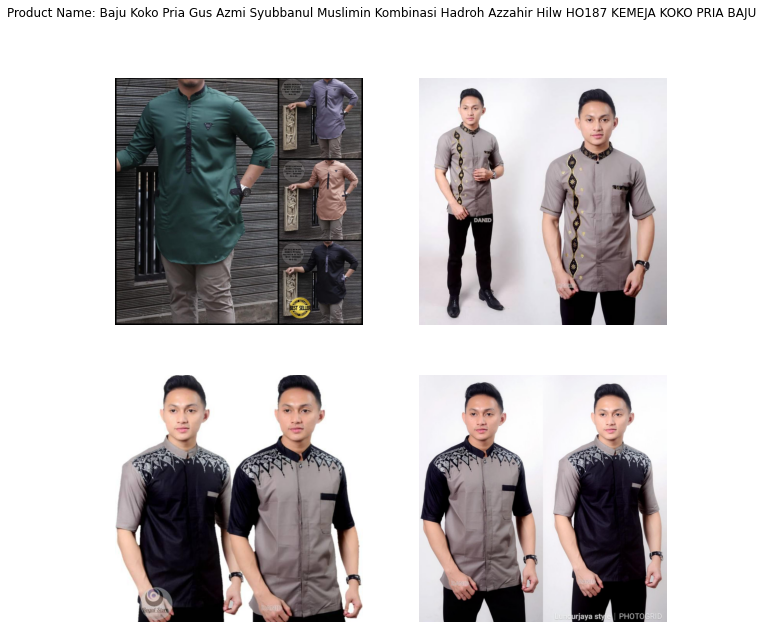

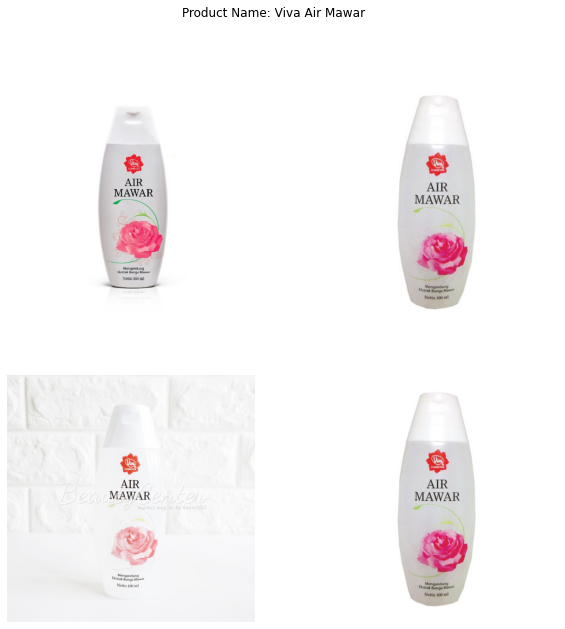

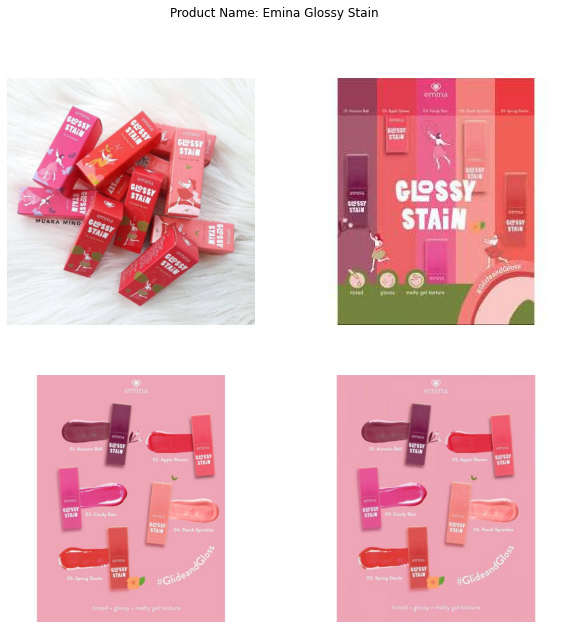

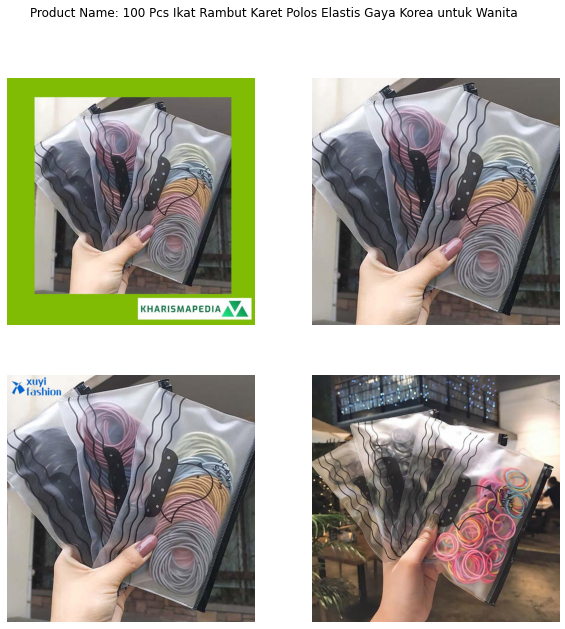

In [10]:
top5_products = train['title'].value_counts()[:5].index.tolist()
for title in top5_products:
    plot_from_title(title)

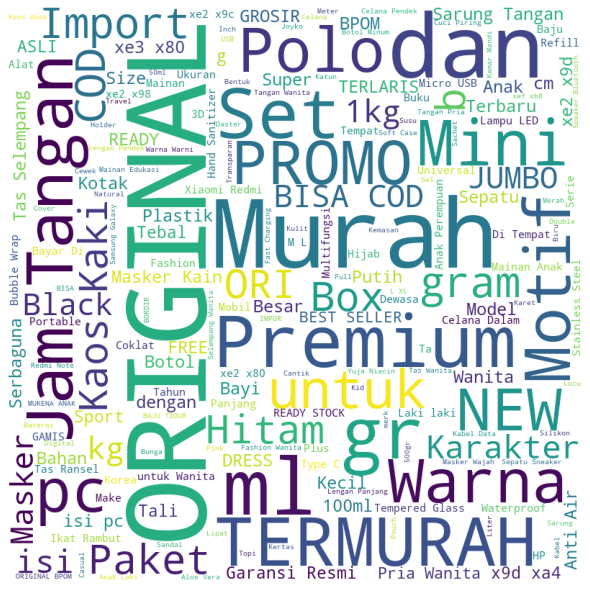

In [11]:
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, 
                      height = 800,
                      background_color ='white',
                      min_font_size = 10,
                      stopwords = stopwords,).generate(' '.join(train['title'])) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [12]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True):

    lst_stopwords = nltk.corpus.stopwords.words("english")
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()    
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text
#Clean Address
train["clean_title"] = train["title"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, ))
#Length of Title
train['clean_title_len'] = train['clean_title'].apply(lambda x: len(x))

#Word Count
train['clean_title_word_count'] =train["clean_title"].apply(lambda x: len(str(x).split(" ")))

#Character Count
train['clean_title_char_count'] = train["clean_title"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

#Average Word Length
train['clean_title_avg_word_length'] = train['clean_title_char_count'] / train['clean_title_word_count']

In [13]:
def plot_distribution(x, title):

    fig = px.histogram(
    train, 
    x = x,
    width = 800,
    height = 500,
    title = title
    )
    
    fig.show()
plot_distribution(x = 'clean_title_len', title = 'Title Length Distribution')

In [14]:
plot_distribution(x = 'clean_title_word_count', title = 'Word Count Distribution')

In [15]:
plot_distribution(x = 'clean_title_char_count', title = 'Character Count Distribution')

In [16]:
!pip install ../input/efficientnetkerasapplications/Keras_Applications-1.0.8-py3-none-any.whl
!pip install ../input/efficientnetkerasapplications/efficientnet-1.1.1-py3-none-any.whl
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import cudf
import cuml
import cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml import PCA
from cuml.neighbors import NearestNeighbors
import tensorflow as tf
import efficientnet.tfkeras as efn
import math
from shutil import copyfile
copyfile(src = "../input/bert-and-tokenization/tokenization.py", dst = "../working/tokenization.py")
import tokenization
import tensorflow_hub as hub

import os
import cv2
import random
from tqdm import tqdm

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import torch
import timm
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
import fasttext as ft

Processing /kaggle/input/efficientnetkerasapplications/Keras_Applications-1.0.8-py3-none-any.whl
Processing /kaggle/input/efficientnetkerasapplications/efficientnet-1.1.1-py3-none-any.whl


In [17]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
BATCH_SIZE = 4
IMAGE_SIZE = [512, 512]
# Seed
SEED = 33
# Verbosity
VERBOSE = 1
# Number of classes
N_CLASSES = 11011

In [18]:
# RESTRICT TENSORFLOW TO 2GB OF GPU RAM
# SO THAT WE HAVE 14GB RAM FOR RAPIDS
LIMIT = 2.0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        #print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
print('We will restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('then RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

We will restrict TensorFlow to max 2GB GPU RAM
then RAPIDS can use 14GB GPU RAM


In [19]:
GET_CV = True
# Flag to check ram allocations (debug)
CHECK_SUB = False

df = cudf.read_csv('../input/shopee-product-matching/test.csv')
# If we are comitting, replace train set for test set and dont get cv
if len(df) > 3:
    GET_CV = False
del df

# Function to get our f1 score
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

# Function to combine predictions
def combine_predictions(row):
    x = np.concatenate([row['image_predictions'], row['text_predictions'], row['oof_text'], row['oof_hash']])
    return ' '.join( np.unique(x) )

# Function to read out dataset
def read_dataset():
    if GET_CV:
        df = pd.read_csv('../input/shopee-product-matching/train.csv')
        tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
        df['matches'] = df['label_group'].map(tmp)
        df['matches'] = df['matches'].apply(lambda x: ' '.join(x))
        if CHECK_SUB:
            df = pd.concat([df, df], axis = 0)
            df.reset_index(drop = True, inplace = True)
        df_cu = cudf.DataFrame(df)
        image_paths = '../input/shopee-product-matching/train_images/' + df['image']
    else:
        df = pd.read_csv('../input/shopee-product-matching/test.csv')
        df_cu = cudf.DataFrame(df)
        image_paths = '../input/shopee-product-matching/test_images/' + df['image']
        
    return df, df_cu, image_paths


# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Function to read our test image and return image
def read_image(image):
    image = tf.io.read_file(image)
    image = decode_image(image)
    return image

# Function to get our dataset that read images
def get_dataset(image):
    dataset = tf.data.Dataset.from_tensor_slices(image)
    dataset = dataset.map(read_image, num_parallel_calls = AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [20]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)
    
    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output
    
    
    

In [21]:
# Function to get the embeddings of our images with the fine-tuned model
def get_image_embeddings(image_paths):
    embeds = []
    
    margin = ArcMarginProduct(
            n_classes = N_CLASSES, 
            s = 30, 
            m = 0.5, 
            name='head/arc_margin', 
            dtype='float32'
            )

    inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')
    x = efn.EfficientNetB3(weights = None, include_top = False)(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = margin([x, label])
        
    output = tf.keras.layers.Softmax(dtype='float32')(x)

    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])
    model.load_weights('../input/efficientnet/EfficientNetB3_512_42.h5')
    model = tf.keras.models.Model(inputs = model.input[0], outputs = model.layers[-4].output)
    print(model.summary())
    chunk = 5000
    iterator = np.arange(np.ceil(len(df) / chunk))
    for j in iterator:
        a = int(j * chunk)
        b = int((j + 1) * chunk)
        image_dataset = get_dataset(image_paths[a:b])
        image_embeddings = model.predict(image_dataset)
        embeds.append(image_embeddings)
    del model
    image_embeddings = np.concatenate(embeds)
    print(f'Our image embeddings shape is {image_embeddings.shape}')
    del embeds
    gc.collect()
    return image_embeddings

# Return tokens, masks and segments from a text array or series
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [22]:
# Function to get our text title embeddings using a pre-trained bert model
def get_text_embeddings(df, max_len = 70):
    embeds = []
    module_url = "../input/bert-en-uncased-l24-h1024-a16-1"
    bert_layer = hub.KerasLayer(module_url, trainable = True)
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
    text = bert_encode(df['title'].values, tokenizer, max_len = max_len)
    
    margin = ArcMarginProduct(
            n_classes = 11014, 
            s = 30, 
            m = 0.5, 
            name='head/arc_margin', 
            dtype='float32'
            )
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    label = tf.keras.layers.Input(shape = (), name = 'label')

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    x = margin([clf_output, label])
    output = tf.keras.layers.Softmax(dtype='float32')(x)
    model = tf.keras.models.Model(inputs = [input_word_ids, input_mask, segment_ids, label], outputs = [output])
    
    model.load_weights('../input/bert-and-tokenization/Bert_123.h5')
    model = tf.keras.models.Model(inputs = model.input[0:3], outputs = model.layers[-4].output)
    chunk = 5000
    iterator = np.arange(np.ceil(len(df) / chunk))
    for j in iterator:
        a = int(j * chunk)
        b = int((j + 1) * chunk)
        text_chunk = ((text[0][a:b], text[1][a:b], text[2][a:b]))
        text_embeddings = model.predict(text_chunk, batch_size = BATCH_SIZE)
        embeds.append(text_embeddings)
    print(model.summary())
    del model
    text_embeddings = np.concatenate(embeds)
    print(f'Our text embeddings shape is {text_embeddings.shape}')
    del embeds
    gc.collect()
    return text_embeddings

In [23]:
# Function to get 50 nearest neighbors of each image and apply a distance threshold to maximize cv
def get_neighbors(df, embeddings, KNN = 50, image = True):
    model = NearestNeighbors(n_neighbors = KNN)
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    
    # Iterate through different thresholds to maximize cv, run this in interactive mode, then replace else clause with a solid threshold
    if GET_CV:
        if image:
            thresholds = list(np.arange(4.5, 5.0, 0.1))
        else:
            thresholds = list(np.arange(31, 35, 1))
        scores = []
        for threshold in thresholds:
            predictions = []
            for k in range(embeddings.shape[0]):
                idx = np.where(distances[k,] < threshold)[0]
                ids = indices[k,idx]
                posting_ids = ' '.join(df['posting_id'].iloc[ids].values)
                predictions.append(posting_ids)
            df['pred_matches'] = predictions
            df['f1'] = f1_score(df['matches'], df['pred_matches'])
            score = df['f1'].mean()
            print(f'Our f1 score for threshold {threshold} is {score}')
            scores.append(score)
        thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
        max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
        best_threshold = max_score['thresholds'].values[0]
        best_score = max_score['scores'].values[0]
        print(f'Our best score is {best_score} and has a threshold {best_threshold}')
        
        # Use threshold
        predictions = []
        for k in range(embeddings.shape[0]):
            ids = np.array([])
            # Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
            if image:
                idx = np.where(distances[k,] < 3.3)[0]
                ids = indices[k,idx]
            else:
                idx = np.where(distances[k,] < 20.0)[0]
                ids = indices[k,idx]
                if (len(idx)>1):
                    arr = distances[k,np.where(distances[k,]<20)[0]][1:]
                    mean = np.mean(arr)
                    standard_deviation = np.std(arr)
                    if(standard_deviation>0):
                        distance_from_mean = abs(arr - mean)
                        max_deviations = 2
                        not_outlier = distance_from_mean < max_deviations * standard_deviation
                        max_dist = arr[not_outlier][-1]
                        idx = np.where(distances[k,] <= max_dist)[0]
                        ids = indices[k,idx]
            posting_ids = df['posting_id'].iloc[ids].values
            predictions.append(posting_ids)
    
    # Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
    else:
        predictions = []
        for k in tqdm(range(embeddings.shape[0])):
            ids = np.array([])
            if image:
                idx = np.where(distances[k,] < 3.3)[0]
                ids = indices[k,idx]
            else:
                idx = np.where(distances[k,] < 16.0)[0]
                ids = indices[k,idx]
                if (len(idx)>1):
                    arr = distances[k,np.where(distances[k,]<16.0)[0]][1:]
                    mean = np.mean(arr)
                    standard_deviation = np.std(arr)
                    if(standard_deviation>0):
                        distance_from_mean = abs(arr - mean)
                        max_deviations = 2
                        not_outlier = distance_from_mean < max_deviations * standard_deviation
                        max_dist = arr[not_outlier][-1]
                        idx = np.where(distances[k,] <= max_dist)[0]
                        ids = indices[k,idx]
            
            posting_ids = df['posting_id'].iloc[ids].values
            predictions.append(posting_ids)
        
    del model, distances, indices
    gc.collect()
    return df, predictions

In [24]:
df, df_cu, image_paths = read_dataset()
image_embeddings = get_image_embeddings(image_paths)
text_embeddings = get_text_embeddings(df)
gc.collect()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp1 (InputLayer)            [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnet-b3 (Functional) (None, None, None, 1536)  10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
Total params: 10,783,528
Trainable params: 10,696,232
Non-trainable params: 87,296
_________________________________________________________________
None
Our image embeddings shape is (34250, 1536)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 70)]         0                                            
_________

370597

In [25]:
df, image_predictions = get_neighbors(df, image_embeddings, KNN = 25, image = True)

Our f1 score for threshold 4.5 is 0.8024185471690268
Our f1 score for threshold 4.6 is 0.7697500046045407
Our f1 score for threshold 4.699999999999999 is 0.7245187689828777
Our f1 score for threshold 4.799999999999999 is 0.6700720196522135
Our f1 score for threshold 4.899999999999999 is 0.611189651816497
Our best score is 0.8024185471690268 and has a threshold 4.5


In [26]:
df, text_predictions = get_neighbors(df, text_embeddings, KNN = 25, image = False)

Our f1 score for threshold 31 is 0.28753145043382894
Our f1 score for threshold 32 is 0.28753145043382894
Our f1 score for threshold 33 is 0.28753145043382894
Our f1 score for threshold 34 is 0.28753145043382894
Our best score is 0.28753145043382894 and has a threshold 31


In [27]:
from cuml.feature_extraction.text import TfidfVectorizer

model = TfidfVectorizer(stop_words=None, binary=True, max_features=25000)
text_embeddings2 = model.fit_transform(df_cu.title).toarray()
print('text embeddings shape',text_embeddings2.shape)

/opt/conda/lib/python3.7/site-packages/cudf/core/join/join.py:368: UserWarning:

can't safely cast column from right with type int32 to uint16, upcasting to int32



text embeddings shape (34250, 25000)


In [28]:
preds = []
CHUNK = 1024*4

print('Finding similar titles...')
CTS = len(df_cu)//CHUNK
if len(df_cu)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(df_cu))
    print('chunk',a,'to',b)
    
    # COSINE SIMILARITY DISTANCE
    # cts = np.dot( text_embeddings, text_embeddings[a:b].T).T
    cts = cupy.matmul(text_embeddings2, text_embeddings2[a:b].T).T
    
    for k in range(b-a):
        # IDX = np.where(cts[k,]>0.75)[0]
        IDX = cupy.where(cts[k,]>0.7)[0]
        o = df_cu.iloc[cupy.asnumpy(IDX)].posting_id.to_pandas().values
        preds.append(o)
        
del model, text_embeddings2

Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [29]:
df_cu['oof_text'] = preds

Images

In [30]:
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

In [31]:
class CFG:
    img_size = 512
    batch_size = 10
    seed = 2020
    
    device = 'cuda'
    classes = 11014
    
    model_name = 'eca_nfnet_l0'
    model_path = '../input/shopee-pytorch-models/arcface_512x512_nfnet_l0 (mish).pt'
    
    scale = 30
    margin = 0.5

In [32]:
def read_dataset():
    df = pd.read_csv('../input/shopee-product-matching/test.csv')
    df_cu = cudf.DataFrame(df)
    image_paths = '../input/shopee-product-matching/test_images/' + df['image']
    return df, df_cu, image_paths

In [33]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(CFG.seed)

In [34]:
def get_image_predictions(df, embeddings,threshold = 0.0):
    
    if len(df) > 3:
        KNN = 50
    else : 
        KNN = 3
    
    model = NearestNeighbors(n_neighbors = KNN, metric = 'cosine')
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    
    predictions = []
    for k in tqdm(range(embeddings.shape[0])):
        idx = np.where(distances[k,] < threshold)[0]
        ids = indices[k,idx]
        posting_ids = df['posting_id'].iloc[ids].values
        predictions.append(posting_ids)
        
    del model, distances, indices
    gc.collect()
    return predictions

In [35]:
def get_test_transforms():

    return A.Compose(
        [
            A.Resize(CFG.img_size,CFG.img_size,always_apply=True),
            A.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

In [36]:
class ShopeeDataset(Dataset):
    def __init__(self, image_paths, transforms=None):

        self.image_paths = image_paths
        self.augmentations = transforms

    def __len__(self):
        return self.image_paths.shape[0]

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
    
        return image,torch.tensor(1)

In [37]:
class ArcMarginProduct_Image(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.4, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct_Image, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin
        
    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale
        
        return output

In [38]:
class ShopeeModel(nn.Module):

    def __init__(
        self,
        n_classes = CFG.classes,
        model_name = CFG.model_name,
        fc_dim = 512,
        margin = CFG.margin,
        scale = CFG.scale,
        use_fc = True,
        pretrained = False):


        super(ShopeeModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))
        
        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif model_name == 'efficientnet_b3':
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif model_name == 'tf_efficientnet_b5_ns':
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
            
        elif model_name == 'eca_nfnet_l0':
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(final_in_features, fc_dim)
        self.bn = nn.BatchNorm1d(fc_dim)
        self._init_params()
        final_in_features = fc_dim

        self.final = ArcMarginProduct_Image(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)
        
    def forward(self, image, label):
        feature = self.extract_feat(image)
        #logits = self.final(feature,label)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

In [39]:
class Mish_func(torch.autograd.Function):
    
    """from: https://github.com/tyunist/memory_efficient_mish_swish/blob/master/mish.py"""
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2)
        
        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 
    
class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)
    
    
def replace_activations(model, existing_layer, new_layer):
    
    """A function for replacing existing activation layers"""
    
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [40]:
def get_image_embeddings1(image_paths, model_name = CFG.model_name):
    embeds = []
    
    model = ShopeeModel(model_name = model_name)
    model.eval()
    
    if model_name == 'eca_nfnet_l0':
        model = replace_activations(model, torch.nn.SiLU, Mish())

    model.load_state_dict(torch.load(CFG.model_path))
    model = model.to(CFG.device)

    
    image_dataset = ShopeeDataset(image_paths=image_paths,transforms=get_test_transforms())
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=CFG.batch_size,
        pin_memory=True,
        drop_last=False,
        num_workers=4
    )
    
    with torch.no_grad():
        for img,label in tqdm(image_loader): 
            img = img.cuda()
            label = label.cuda()
            feat = model(img,label)
            image_embeddings = feat.detach().cpu().numpy()
            embeds.append(image_embeddings)
    del model
    
    image_embeddings = np.concatenate(embeds)
    print(f'Our image embeddings shape is {image_embeddings.shape}')
    del embeds
    gc.collect()
    return image_embeddings

In [41]:
df_image,df_image_cu,image_paths = read_dataset()
df_image.head()

posting_id                                 image       image_phash  \
0  test_2255846744  0006c8e5462ae52167402bac1c2e916e.jpg  ecc292392dc7687a   
1  test_3588702337  0007585c4d0f932859339129f709bfdc.jpg  e9968f60d2699e2c   
2  test_4015706929  0008377d3662e83ef44e1881af38b879.jpg  ba81c17e3581cabe   

                                               title  
0  Edufuntoys - CHARACTER PHONE ada lampu dan mus...  
1  (Beli 1 Free Spatula) Masker Komedo | Blackhea...  
2   READY Lemonilo Mie instant sehat kuah dan goreng

In [42]:
image_embeddings1 = get_image_embeddings1(image_paths.values)
image_predictions1 = get_image_predictions(df_image, image_embeddings1, threshold = 0.3)

Building Model Backbone for eca_nfnet_l0 model


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Our image embeddings shape is (3, 512)


100%|██████████| 3/3 [00:00<00:00, 1385.94it/s]


In [43]:
# Function to combine predictions
def combine_predictions(row):
    x = np.concatenate([row['image_predictions'], row['text_predictions'], row['oof_text'], row['oof_hash']])
    return ' '.join( np.unique(x) )

In [44]:
# Function to combine predictions
def combine_predictions_oof(row):
    x = np.concatenate([row['image_predictions'], row['text_predictions'], row['oof_text'], row['oof_hash'],row['oof_image']])
    return ' '.join( np.unique(x) )

In [45]:
# Concatenate image predctions with text predictions
tmp = df.groupby('image_phash').posting_id.agg('unique').to_dict()
df['oof_hash'] = df.image_phash.map(tmp)
if GET_CV:
    df['image_predictions'] = image_predictions
    df['text_predictions'] = text_predictions
    df['oof_text'] = df_cu['oof_text'].to_pandas().values
    df['pred_matches'] = df.apply(combine_predictions, axis = 1)
    df['f1'] = f1_score(df['matches'], df['pred_matches'])
    score = df['f1'].mean()
    print(f'Our final f1 cv score is {score}')
    df['matches'] = df['pred_matches']
    df[['posting_id', 'matches']].to_csv('submission.csv', index = False)
else:
    df['image_predictions'] = image_predictions
    df['oof_text'] = df_cu['oof_text'].to_pandas().values
    df['text_predictions'] = text_predictions
    df['oof_image']=image_predictions1
    df['matches'] = df.apply(combine_predictions_oof, axis = 1)
    df[['posting_id', 'matches']].to_csv('submission.csv', index = False)

Our final f1 cv score is 0.8725948584833525
